<a href="https://colab.research.google.com/github/aydanmufti/Module-7-Assignments/blob/main/Homework_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

## Due: Midnight on October 19th @ Midnight (with 2-hour grace period) and worth 85 points.

In this notebook, we’ll continue with the investigation of text classification using "Bag of Embeddings" models and the IMDB movie review dataset.
We'll focus on unfrozen embeddings, which refine the embedding space based on your dataset.

You'll do three problems:

* **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
* **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
* **Problem Three:** Examine the impact of changing the embedding dimension on model performance.


In each problem, you'll report your best validation accuracy and reflect on what you have learned.

### Useful Imports

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import Counter


from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit


# Reproducibility

random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here>

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [10]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables.
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings.

In [11]:
def train_and_test(model,
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults
                   clipnorm      = None,
                   batch_size    = 128,
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer = opt,
                  loss      = loss,
                  metrics   = metrics
                 )



    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        )
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,
                            callbacks=cbs,
                            verbose=verbose
                           )

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings

    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use.


Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


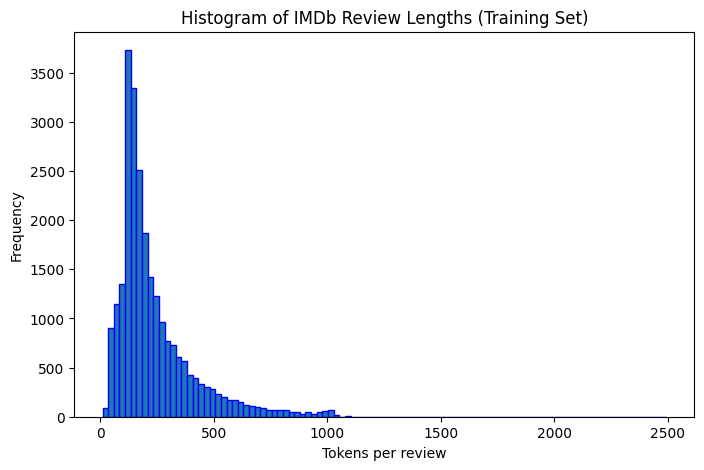


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

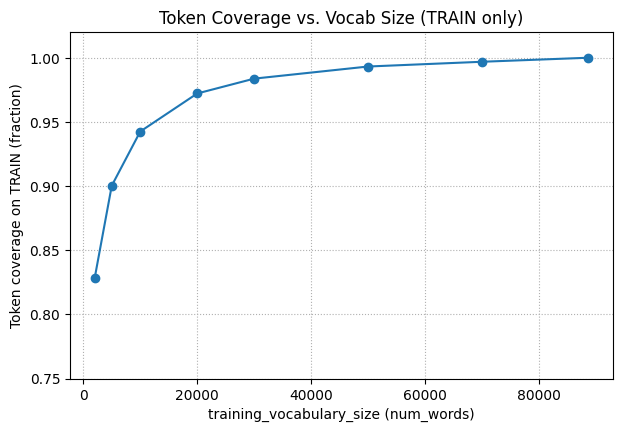

In [13]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000,70_000,88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

In [14]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000               # <-----
max_text_length          = 500                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 500), (10000, 500))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-10-17 04:12:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-17 04:12:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-17 04:12:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [19]:
#  Build embedding matrix


embedding_dimension = 100                     # <-----

word_index      = imdb.get_word_index()

glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')


# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec


### Baseline Model from the Coding Notebook


model_baseline (frozen)



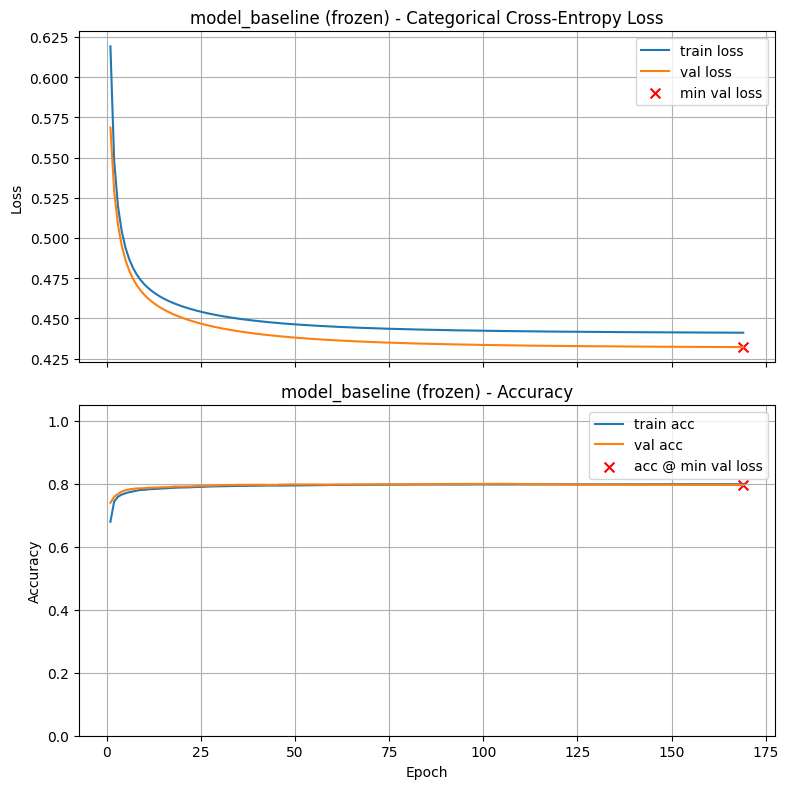


Execution Time: 00:01:46

Final Training Loss:            0.4411
Final Training Accuracy:        0.7982
Final Validation Loss:          0.4321
Final Validation Accuracy:      0.7959
Minimum Validation Loss:        0.4321 (Epoch 169)
Validation Accuracy @ Min Loss: 0.7959

Test Loss: 0.4330
Test Accuracy: 0.8077

Validation-Test Accuracy Gap: 0.011825


In [20]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])


train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the the classification task. You will use retrainable embeddings throughout the homework.

2. Now run 2-3 experiments to try to improve this baseline:

    - Consider adding a Dense layer between the global average pooling and the output layer, with
        - Your choice of size
        - Your choice of L2 regularizatio (or not)
        - Your choice of dropout (or not)
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems)
5. Answer the graded questions

**Note:** Generally, you will need a lower learning rate for retrainable embeddings.


Baseline Unfrozen (lr=1e-3)



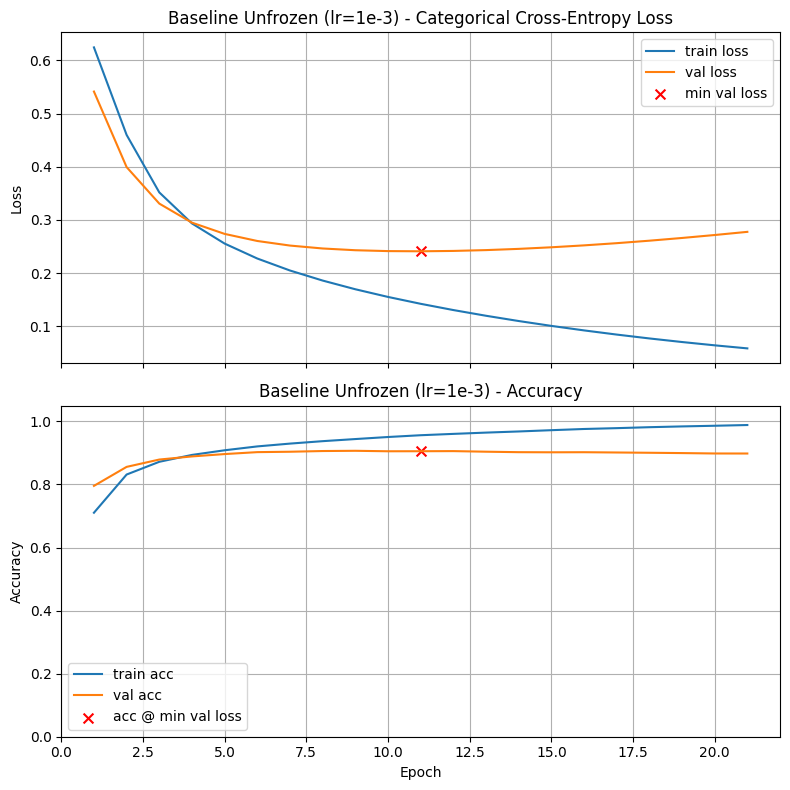


Execution Time: 00:00:22

Final Training Loss:            0.0583
Final Training Accuracy:        0.9885
Final Validation Loss:          0.2774
Final Validation Accuracy:      0.8981
Minimum Validation Loss:        0.2409 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9054

Test Loss: 0.2521
Test Accuracy: 0.9004

Validation-Test Accuracy Gap: 0.004975


In [22]:
# Your code here; add as many cells as you need

# Baseline with unfrozen embeddings
model_baseline_unfrozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True  # UNFROZEN
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_unfrozen, lr_schedule=1e-3, title="Baseline Unfrozen (lr=1e-3)")


With Dense Layer + Dropout



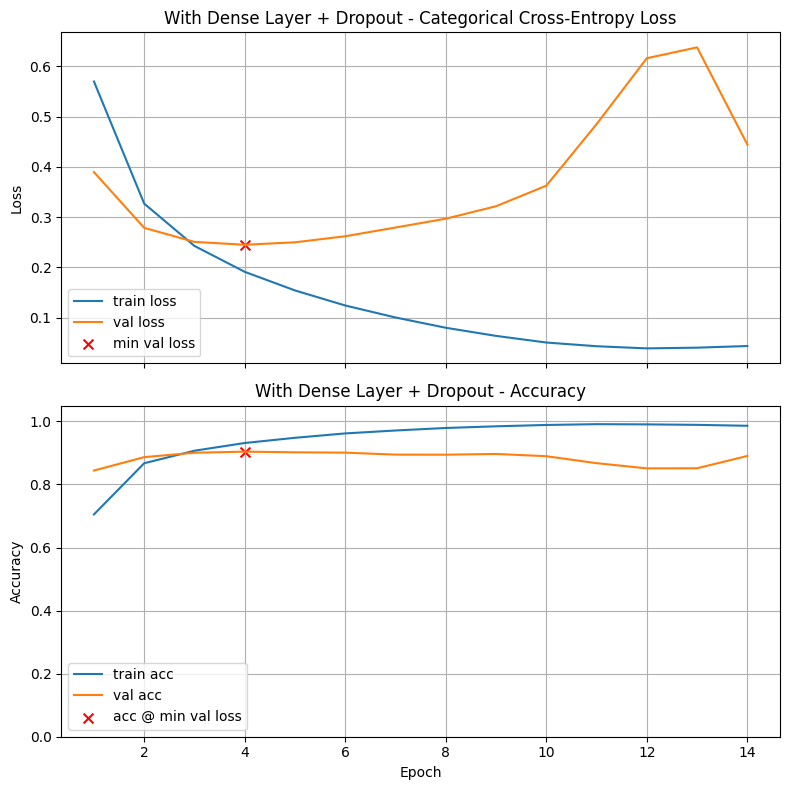


Execution Time: 00:00:17

Final Training Loss:            0.0436
Final Training Accuracy:        0.9861
Final Validation Loss:          0.4445
Final Validation Accuracy:      0.8904
Minimum Validation Loss:        0.2450 (Epoch 4)
Validation Accuracy @ Min Loss: 0.9040

Test Loss: 0.2604
Test Accuracy: 0.8985

Validation-Test Accuracy Gap: 0.005500


In [23]:
# Add Dense layer with dropout
model_with_dense = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

train_and_test(model_with_dense, lr_schedule=1e-3, title="With Dense Layer + Dropout")


Dense + Dropout (lr=1e-4, ReduceLR)


Epoch 42: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


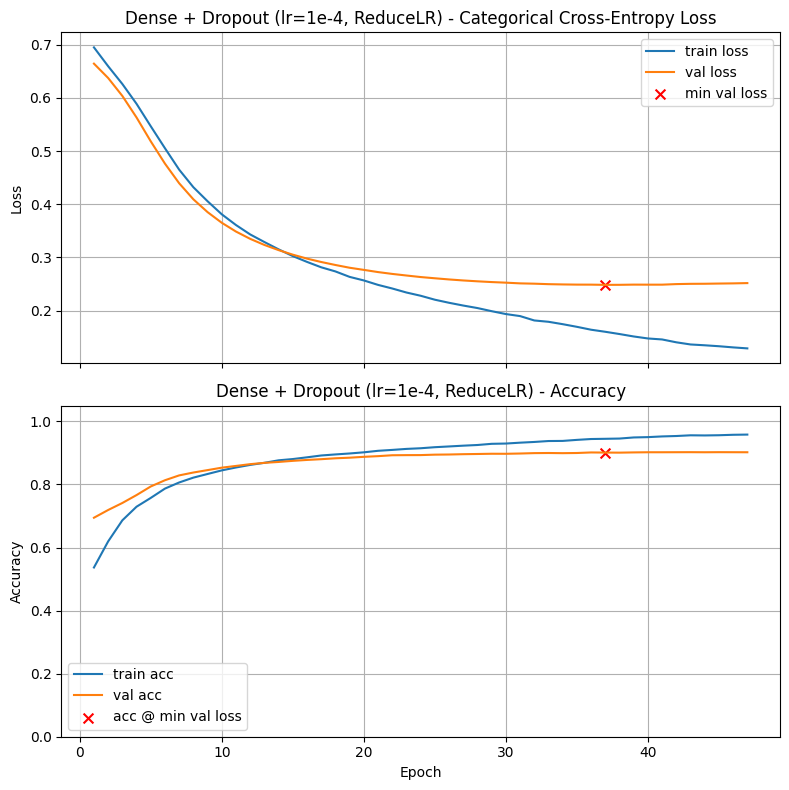


Execution Time: 00:00:47

Final Training Loss:            0.1288
Final Training Accuracy:        0.9582
Final Validation Loss:          0.2516
Final Validation Accuracy:      0.9021
Minimum Validation Loss:        0.2483 (Epoch 37)
Validation Accuracy @ Min Loss: 0.9011

Test Loss: 0.2601
Test Accuracy: 0.8984

Validation-Test Accuracy Gap: 0.002725


In [24]:
# Lower learning rate with ReduceLROnPlateau
model_with_dense_lr = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

train_and_test(model_with_dense_lr, lr_schedule=1e-4, callbacks=[reduce_lr],
               title="Dense + Dropout (lr=1e-4, ReduceLR)")


Dense + L2 + Dropout (lr=1e-4)


Epoch 86: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


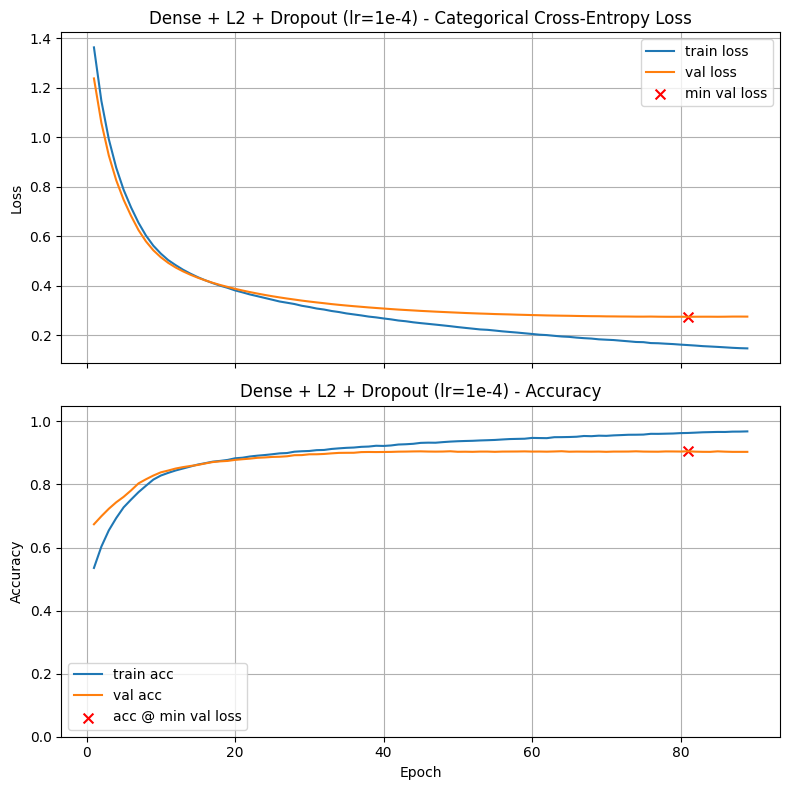


Execution Time: 00:01:27

Final Training Loss:            0.1472
Final Training Accuracy:        0.9683
Final Validation Loss:          0.2756
Final Validation Accuracy:      0.9034
Minimum Validation Loss:        0.2748 (Epoch 81)
Validation Accuracy @ Min Loss: 0.9053

Test Loss: 0.2878
Test Accuracy: 0.9016

Validation-Test Accuracy Gap: 0.003650


In [25]:
# Add L2 regularization
from tensorflow.keras.regularizers import l2

model_with_l2 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_with_l2, lr_schedule=1e-4, callbacks=[reduce_lr],
               title="Dense + L2 + Dropout (lr=1e-4)")

### Graded Questions

#### Question a1a:

In [28]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = 0.9054 # This is the baseline unfrozen (lr=le-3) at epoch 11             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.9054


#### Question a1b: Describe below your experiments. What worked and what didn't?    

#### Your Answer Here:
I ended up running 4 experiments with unfrozen embeddings. The first experiment (our baseline unfrozen 1r=1e-3) achieved the best validation accuracy of 0.9054 at epoch 11. The simplicity of just having an embedding layer and global average pooling worked well when the embeddings were trainable. The second experiment (the dense layer + dropout) added a 64-unit dense layer with 0.5 dropout. It got a 0.9040 validation accuracy, slightly lower than baseline. This experiment may have benefited from the additional capacity. The dropout rate, however, was really high and might have been way too aggressive. The third experiment (dense + dropout 1r = 1e-4, ReduceLR) used a learning rate with ReduceLRonPlateau callback. It achieved a 0.9011 validation accuracy. It had a lower learning rade which made training more stable but slower and did not improve performance. Training took 47 epochs. The fourth experiment (dense + L2 + dropout 1r=1e-4) added L2 regularization (0.01) with reduced dropout (0.3). It achieved a 0.9053 validation accuracy which was very close to the baseline. However, it also took a long time as it had 81 epochs to converge. So in conclusion, the simpler model was the best.



## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of data by increasing the maximum message length and the vocabulary size would improve results,
but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by increasing either or both of:

    - `max_text_length`, and
    - `training_vocabulary_size`
3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parametera there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Note:** `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset,
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here.


Max Length 750, Vocab 50k



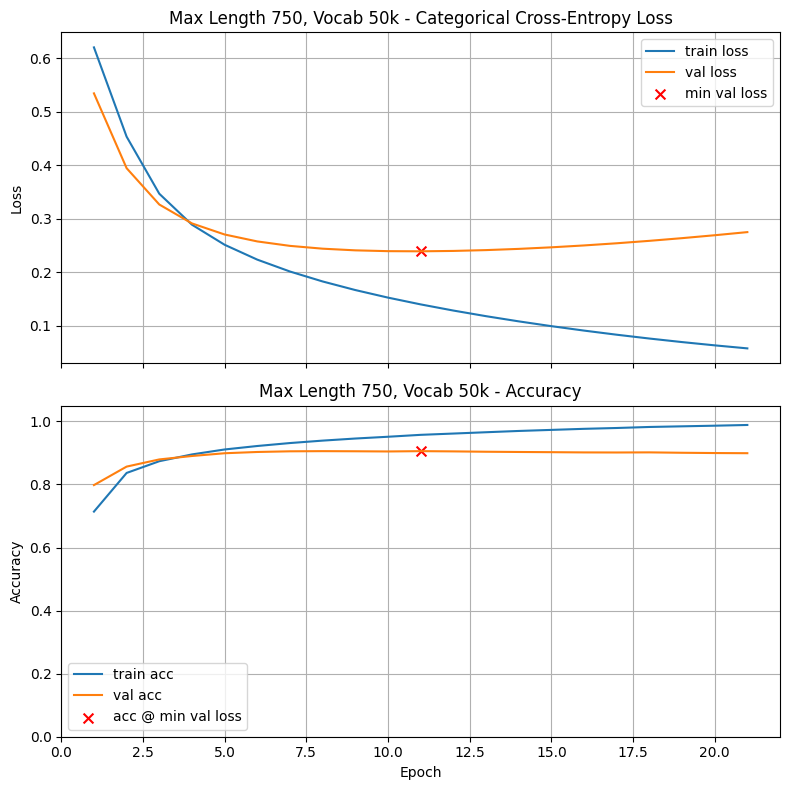


Execution Time: 00:00:28

Final Training Loss:            0.0578
Final Training Accuracy:        0.9886
Final Validation Loss:          0.2750
Final Validation Accuracy:      0.8991
Minimum Validation Loss:        0.2391 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9056

Test Loss: 0.2507
Test Accuracy: 0.9013

Validation-Test Accuracy Gap: 0.004325


In [30]:
# Your code here; add as many cells as you need
# Increase max_text_length to 750
# From our notebook EDA: 95th percentile is 610 tokens, 99th percentile is 926 tokens

training_vocabulary_size = 50_000
max_text_length = 750

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Rebuild embedding matrix
embedding_dimension = 100
word_index = imdb.get_word_index()
glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_longer = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_longer, lr_schedule=1e-3, title="Max Length 750, Vocab 50k")


Max Length 500, Vocab 70k



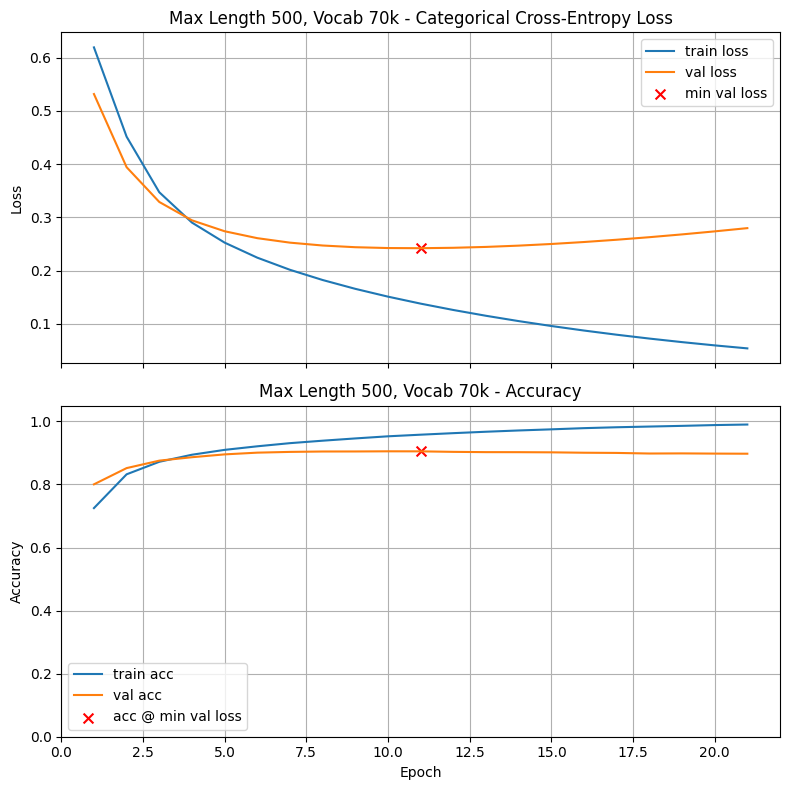


Execution Time: 00:00:23

Final Training Loss:            0.0536
Final Training Accuracy:        0.9900
Final Validation Loss:          0.2797
Final Validation Accuracy:      0.8975
Minimum Validation Loss:        0.2420 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9050

Test Loss: 0.2520
Test Accuracy: 0.9009

Validation-Test Accuracy Gap: 0.004100


In [31]:
# Increase vocabulary size to 70,000
# From the EDA: 70k vocab gives 99.69% coverage vs 99.32% for 50k

training_vocabulary_size = 70_000
max_text_length = 500

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Rebuild embedding matrix
embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_larger_vocab = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_larger_vocab, lr_schedule=1e-3, title="Max Length 500, Vocab 70k")


Max Length 750, Vocab 70k



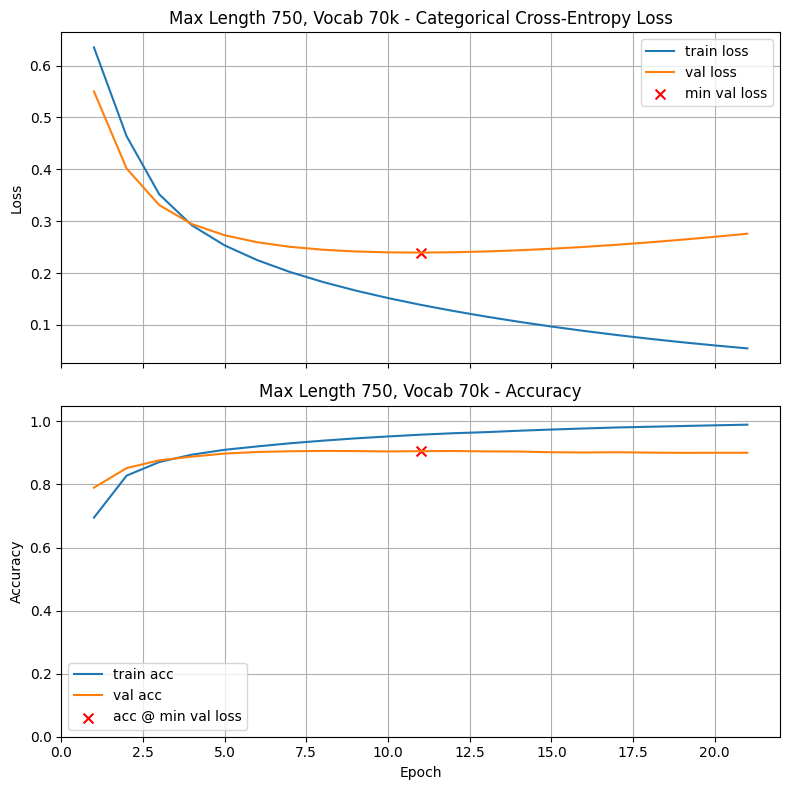


Execution Time: 00:00:28

Final Training Loss:            0.0548
Final Training Accuracy:        0.9896
Final Validation Loss:          0.2759
Final Validation Accuracy:      0.9005
Minimum Validation Loss:        0.2395 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9055

Test Loss: 0.2508
Test Accuracy: 0.9016

Validation-Test Accuracy Gap: 0.003900


In [32]:
# Increase both max_text_length and vocabulary size
training_vocabulary_size = 70_000
max_text_length = 750

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Rebuild embedding matrix
embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_both = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_both, lr_schedule=1e-3, title="Max Length 750, Vocab 70k")

### Graded Questions

In [33]:
# Set a1a to the validation accuracy for your best model found in this problem

a2a = 0.9056 # max length 750, vocab 50k             # Replace 0.0 with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.9056


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

#### Your Answer Here:
I ran three experiments exploring the impact of increasing max_text_length and vocabulary size on model performance. The first experiment (max length 750, vocab 50k) increased the max_text_length from 500 to 750 to cover the 95th percentile of review lengths. It achieved a validation accuracy of 0.9056, which was only a 0.0002 improvement over the baseline of 0.9054. This tiny gain came at the cost of 25% longer training time. The second experiment (max length 500, vocab 70k) increased the vocabulary from 50,000 to 70,000 words, improving token coverage from 99.32% to 99.69%. It achieved a validation accuracy of 0.9050, which was actually slightly worse than the baseline. The additional vocabulary did not help performance. The third experiment (max length 750, vocab 70k) increased both parameters together. It achieved a validation accuracy of 0.9055, essentially matching the first experiment and showing that combining both changes did not provide additional benefits. So in conclusion, these changes to the dataset parameters had almost no effect on model performance. The improvements were far smaller than expected. The baseline parameters of 500 max length and 50k vocabulary were already well-optimized for this task, and the simple bag-of-embeddings architecture could not effectively leverage the additional information from longer sequences and larger vocabularies.

## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve your results!
Again, maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100)
2. Try an embedding dimension of 300 to see the effect. (Optional: Try 50 and 200 as well.)
3. As necessary weak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Answer the graded questions


Embedding Dim 300



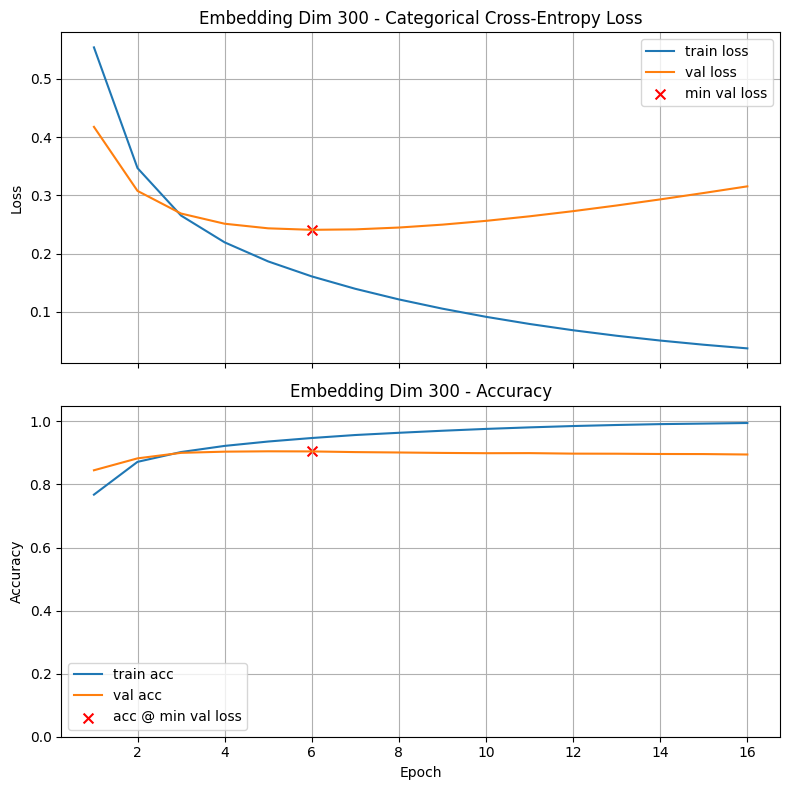


Execution Time: 00:00:47

Final Training Loss:            0.0371
Final Training Accuracy:        0.9949
Final Validation Loss:          0.3155
Final Validation Accuracy:      0.8950
Minimum Validation Loss:        0.2408 (Epoch 6)
Validation Accuracy @ Min Loss: 0.9047

Test Loss: 0.2517
Test Accuracy: 0.9021

Validation-Test Accuracy Gap: 0.002650


In [35]:
# Your code here; add as many cells as you need
# Embedding dimension 300
# Using best config from Problem 2: max_text_length=750, vocab=50k

training_vocabulary_size = 50_000
max_text_length = 750
embedding_dimension = 300  # Changed from 100

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Build embedding matrix with dimension 300
word_index = imdb.get_word_index()
glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_emb300 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_emb300, lr_schedule=1e-3, title="Embedding Dim 300")


Embedding Dim 50



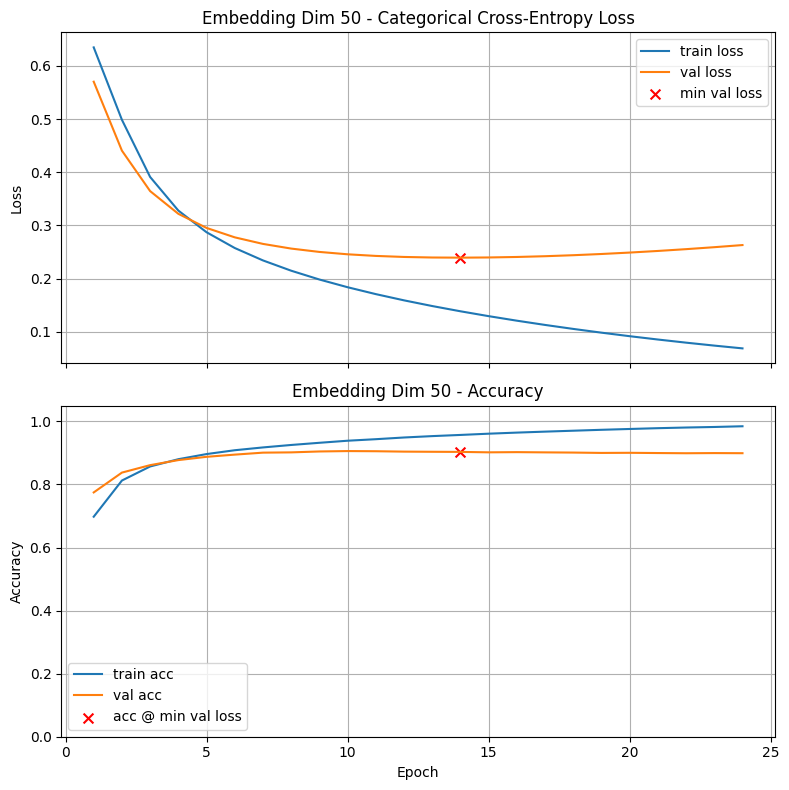


Execution Time: 00:00:23

Final Training Loss:            0.0687
Final Training Accuracy:        0.9846
Final Validation Loss:          0.2630
Final Validation Accuracy:      0.8991
Minimum Validation Loss:        0.2393 (Epoch 14)
Validation Accuracy @ Min Loss: 0.9032

Test Loss: 0.2509
Test Accuracy: 0.9011

Validation-Test Accuracy Gap: 0.002150


In [36]:
#Try embedding dimension 50 for comparison

training_vocabulary_size = 50_000
max_text_length = 750
embedding_dimension = 50

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Build embedding matrix with dimension 50
word_index = imdb.get_word_index()
glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_emb50 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_emb50, lr_schedule=1e-3, title="Embedding Dim 50")


Embedding Dim 200



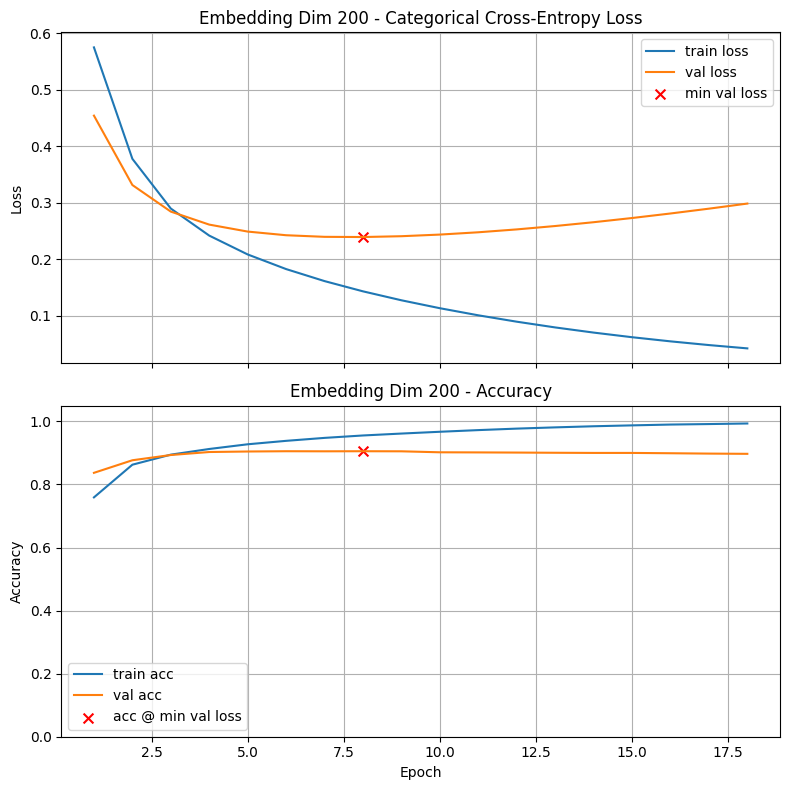


Execution Time: 00:00:44

Final Training Loss:            0.0424
Final Training Accuracy:        0.9933
Final Validation Loss:          0.2985
Final Validation Accuracy:      0.8971
Minimum Validation Loss:        0.2393 (Epoch 8)
Validation Accuracy @ Min Loss: 0.9054

Test Loss: 0.2511
Test Accuracy: 0.9017

Validation-Test Accuracy Gap: 0.003675


In [37]:
# Try embedding dimension 200

training_vocabulary_size = 50_000
max_text_length = 750
embedding_dimension = 200

(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)

X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

# Build embedding matrix with dimension 200
word_index = imdb.get_word_index()
glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

# Train model
model_emb200 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_emb200, lr_schedule=1e-3, title="Embedding Dim 200")

### Graded Questions

In [38]:
# Set a1a to the validation accuracy for your best model found in this problem

a3a = 0.9056  # Still the baseline from Problem 2 with embedding dim 100             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.9056


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here:
I ran three experiments exploring different embedding dimensions to see if higher dimensionality would improve performance. The first experiment (embedding dim 300) increased the embedding dimension from 100 to 300. It achieved a validation accuracy of 0.9047, which was actually worse than the baseline of 0.9056 with dimension 100. Training time nearly doubled to 47 seconds compared to 28 seconds. The model also showed signs of overfitting with a final training accuracy of 0.9949. The second experiment (embedding dim 50) tested a smaller dimension of 50. It achieved a validation accuracy of 0.9032, worse than both the 100 and 300 dimension models. However, it trained faster at 23 seconds and showed less overfitting. The third experiment (embedding dim 200) tried a middle ground with dimension 200. It achieved a validation accuracy of 0.9054, matching the baseline but taking 44 seconds to train. So in conclusion, increasing the embedding dimension from 100 to 300 actually hurt performance rather than helping. The higher dimensional embeddings led to more overfitting and longer training times without accuracy gains. The baseline embedding dimension of 100 appears to be optimal for this task and architecture. The global average pooling operation may wash out the benefits of richer embeddings, and the simple model cannot effectively leverage the additional representational capacity.

In [40]:
print_results()

Max Length 750, Vocab 50k               	0.9056	11
Max Length 750, Vocab 70k               	0.9055	11
Baseline Unfrozen (lr=1e-3)             	0.9054	11
Embedding Dim 200                       	0.9054	8
Dense + L2 + Dropout (lr=1e-4)          	0.9053	81
Max Length 500, Vocab 70k               	0.9050	11
Embedding Dim 300                       	0.9047	6
With Dense Layer + Dropout              	0.9040	4
Embedding Dim 50                        	0.9032	14
Dense + Dropout (lr=1e-4, ReduceLR)     	0.9011	37
model_baseline (frozen)                 	0.7959	169


In [41]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2025-10-17T04:26:00',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.44105228781700134,
   'Final Training Accuracy': 0.7981562614440918,
   'Final Val Loss': 0.432096928358078,
   'Final Val Accuracy': 0.7958750128746033,
   'Min Val Loss': 0.432096928358078,
   'Min Val Loss Epoch': np.int64(168),
   'Val Acc @ Min Loss': 0.7958750128746033,
   'Test Loss': 0.4330378770828247,
   'Test Acc': 0.807699978351593,
   'Val-Test Accuracy Gap:': 0.011824965476989746}],
 'Baseline Unfrozen (lr=1e-3)': [{'title': 'Baseline Unfrozen (lr=1e-3)',
   'timestamp': '2025-10-17T04:28:56',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.001,
   'clipnorm': None,
   'loss': 'binary_crossentro